In [1]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Simulating the Maxwell-Boltzmann Distribution with `torch`

In this notebook, we will simulate the collision of classical free particles in a box and demonstrate how the distribution of their velocities converges to a **Maxwell-Boltzman distribution**. In order to simulate smoothly thousands of particles we will exploit the computation powers provided by the `torch` package, a popular Python package in the Deep Learning community which allows performing tensor computations with strong **GPU** acceleration. 

Before we jump into coding our particle simulation, we'll take a quick look at the basics of `torch`, comparing it to common operations in `numpy`. Then, we'll get into the theory behind the Maxwell-Boltzmann distribution. Finally, we'll whip up an animated gif to visualize the simulation of thousands of particles bouncing around, showing how their velocity distribution evolves over time.

## An introduction to Torch and comparison with Numpy

The building blocks of the `torch` package are the so-called **tensor** object. A tensor is a mathemtical object with specific properties and there is whole branch of maths dealing with this kind of entities (*tensor algebra* and *differential geometry*). However, for the purpose of this notebook, we could consider a tensor merely as a multi-dimensional extension of the concept of vector and matrix. Indeed, a vector can be informally defined as an object whose components depend on a single index $i$ (e.g. $v_i$); a matrix is specified by components depending on two indices, $i,j$, which define rows and columns. A tensor is a set of components depending on more than 2 indices. 

From a computational point of view, torch tensors are closely resembles `numpy` arrays and so they can be manipulated in a very similar manner. There is one major difference between torch tensors and numpy array that we will discuss shortly below. Let's now see how we can work with torch tensors and let's look at the major methods provided by the package:

In [2]:
# We define a 1D tensor, using linspace, similar to numpy.linspace
t = torch.linspace(0,1000, 50)

In [3]:
t

tensor([   0.0000,   20.4082,   40.8163,   61.2245,   81.6327,  102.0408,
         122.4490,  142.8571,  163.2653,  183.6735,  204.0816,  224.4898,
         244.8979,  265.3061,  285.7143,  306.1224,  326.5306,  346.9388,
         367.3469,  387.7551,  408.1633,  428.5714,  448.9796,  469.3878,
         489.7959,  510.2041,  530.6122,  551.0204,  571.4286,  591.8367,
         612.2449,  632.6531,  653.0612,  673.4694,  693.8776,  714.2857,
         734.6939,  755.1021,  775.5102,  795.9184,  816.3265,  836.7347,
         857.1429,  877.5510,  897.9592,  918.3674,  938.7755,  959.1837,
         979.5919, 1000.0000])

In [4]:
# We can print the shape of the tensor as follows -> below we have a 1D vector of size 50
t.shape

torch.Size([50])

In [5]:
# Similarly we can defined a 2D tensor, i.e. a NxN matrix. 
t_2d = torch.rand(5, 2)

In [6]:
t_2d

tensor([[0.0293, 0.4042],
        [0.0033, 0.7795],
        [0.6879, 0.2402],
        [0.8995, 0.4291],
        [0.6459, 0.6294]])

In [7]:
t_2d.shape

torch.Size([5, 2])

Above, we have defined a 5x2 matrix using the `rand` method and passing two integers values, respectively specifying the number of rows and column. The method draws $N$ random numbers uniformely distributed in $[0,1]$ for both rows and columns. We can subset the matrix and extract rows or columns as we do with numpy arrays:

In [8]:
# the first row
t_2d[0,:]

tensor([0.0293, 0.4042])

In [9]:
# the first column
t_2d[:,0]

tensor([0.0293, 0.0033, 0.6879, 0.8995, 0.6459])

In [10]:
# Suppose that we want to subset just those elements in the first row where the value is higher than 0.1
t_2d[0]>0.1

tensor([False,  True])

In [11]:
t_2d[0, t_2d[0]>0.1], t_2d[0][t_2d[0]>0.1]

(tensor([0.4042]), tensor([0.4042]))

Notice that there two equivalent ways of subsetting. We can use both: `t_2d[0,t_2d[0]>0.1]`and `t_2d[0][t_2d[0]>0.1]`.

### Tensor Algebra with `torch`

Let now perform some basic algebric operations with torch and let compare with numpy!

In [12]:
# sum of tensors
t1 = torch.rand(10)
t2 = torch.rand(10)

In [13]:
t1, t2

(tensor([0.1628, 0.1028, 0.2738, 0.6157, 0.0304, 0.5008, 0.4862, 0.0126, 0.0970,
         0.3411]),
 tensor([0.0841, 0.2304, 0.7871, 0.1687, 0.4988, 0.0916, 0.5748, 0.6839, 0.2018,
         0.1150]))

In [14]:
t1+t2

tensor([0.2469, 0.3332, 1.0609, 0.7844, 0.5292, 0.5924, 1.0610, 0.6965, 0.2987,
        0.4561])

In [15]:
# product by a scalar
n = 2
t1*n

tensor([0.3256, 0.2055, 0.5476, 1.2314, 0.0608, 1.0016, 0.9723, 0.0251, 0.1939,
        0.6822])

In [16]:
# product of 1D tensors 
t1*t2, (t1*t2).shape

(tensor([0.0137, 0.0237, 0.2155, 0.1039, 0.0152, 0.0459, 0.2795, 0.0086, 0.0196,
         0.0392]),
 torch.Size([10]))

In [17]:
# Let perform now a matrix multiplication
t1_2d = torch.arange(1000).reshape(100,10)
t2_2d = torch.arange(500).reshape(10,50)

To multiply matrix $(i,j)$ times a matrix $(j,k)$, we can use the `.mm` method:

In [18]:
matrix_prod = torch.mm(t1_2d, t2_2d)

In [19]:
matrix_prod

tensor([[  14250,   14295,   14340,  ...,   16365,   16410,   16455],
        [  36750,   36895,   37040,  ...,   43565,   43710,   43855],
        [  59250,   59495,   59740,  ...,   70765,   71010,   71255],
        ...,
        [2196750, 2206495, 2216240,  ..., 2654765, 2664510, 2674255],
        [2219250, 2229095, 2238940,  ..., 2681965, 2691810, 2701655],
        [2241750, 2251695, 2261640,  ..., 2709165, 2719110, 2729055]])

In [20]:
matrix_prod.shape

torch.Size([100, 50])

In [21]:
# Let do the same in numpy
arr1_2d = np.arange(1000).reshape(100,10)
arr2_2d = np.arange(500).reshape(10,50)

In [22]:
arr1_2d@arr2_2d

array([[  14250,   14295,   14340, ...,   16365,   16410,   16455],
       [  36750,   36895,   37040, ...,   43565,   43710,   43855],
       [  59250,   59495,   59740, ...,   70765,   71010,   71255],
       ...,
       [2196750, 2206495, 2216240, ..., 2654765, 2664510, 2674255],
       [2219250, 2229095, 2238940, ..., 2681965, 2691810, 2701655],
       [2241750, 2251695, 2261640, ..., 2709165, 2719110, 2729055]])

Let now compare the performance of torch and numpy multiplying big matrices.  We wil introduce another method called `.to(device)` to move tensor computation on CUDA GPU if available. The piece of code written at the beginning:

`device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')`

checks if CUDA (GPU support) is available on the system. If CUDA is available, it assigns the device to the GPU ('cuda'), otherwise, it assigns it to the CPU ('cpu'). This line ensures that the code can run on both GPU-enabled and CPU-only systems without modification.

In [23]:
r, c = 10000, 10000

# "standard" torch
t1 = torch.rand(r,c)
t2 = torch.rand(c, r)

# cuda torch
t1_cuda = torch.rand(r,c).to(device)
t2_cuda = torch.rand(c, r).to(device)

np1 = np.random.rand(r,c)
np2 = np.random.rand(c,r)

In [24]:
start = time.time()
torch.mm(t1, t2)
execution_time_torch = time.time()-start

start = time.time()
torch.mm(t1_cuda, t2_cuda)
execution_time_torch_cuda = time.time()-start

start = time.time()
np.matmul(np1, np2)
execution_time_numpy = time.time()-start


print(f"Computaton time to multiply ({r},{c})x({c},{r}) with Torch: {execution_time_torch}")
print(f"Computaton time to multiply ({r},{c})x({c},{r}) with Torch on CUDA: {execution_time_torch_cuda}")
print(f"Computaton time to multiply ({r},{c})x({c},{r}) with NumPy: {execution_time_numpy}")

Computaton time to multiply (10000,10000)x(10000,10000) with Torch: 1.460035800933838
Computaton time to multiply (10000,10000)x(10000,10000) with Torch on CUDA: 1.3787789344787598
Computaton time to multiply (10000,10000)x(10000,10000) with NumPy: 6.35419774055481


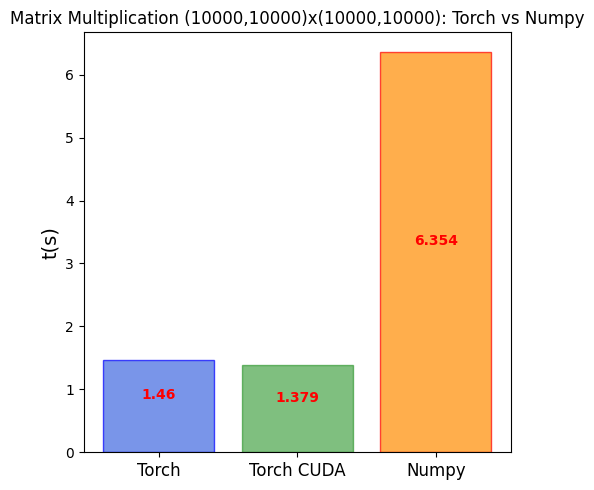

In [25]:
fig, ax = plt.subplots(figsize=(5,5))

bar1 = ax.bar(0, execution_time_torch, color="royalblue", alpha=.7, edgecolor="blue")
bar2 = ax.bar(1, execution_time_torch_cuda, color="green", alpha=.5, edgecolor="green")
bar3 = ax.bar(2, execution_time_numpy, color="darkorange", alpha=.7, edgecolor="red")

# Set the xticks positions and labels
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Torch', 'Torch CUDA', 'Numpy'], fontsize=12)

# Add annotations on top of each bar
for bars in [bar1, bar2, bar3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(bar.get_x() + bar.get_width() / 2, height/2),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold', color='red')

ax.set_title(f"Matrix Multiplication ({r},{c})x({c},{r}): Torch vs Numpy")
ax.set_ylabel("t(s)", fontsize=14)
plt.tight_layout()
plt.show()

### `torch` gradients

The main difference between torch tensors and numpy arrays lies in the fact that torch tensors can automatically keep track of **gradients**, i.e. variations in their components. This feature makes pytorch tensors particularly useful in the implementation of deep learning frameworks such as *neural networks* because they automatic differentiation can be exploited in techniques such as *backpropagation*, at the basis of neural networks training. 

Let's see how gradients are implemented in pytorch.

In [26]:
# Create a tensor with requires_grad=True to track gradients
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

In [27]:
x

tensor([1., 2., 3.], requires_grad=True)

Let define a function depending on the $x_i$ components of the above defined tensor as follows:
$$ y = \sum_i 2x_i^2 $$
The gradient components of $y$ w.r.t. to $x$ are:
$$
(\nabla y)_j \equiv \frac{\partial y}{\partial x_j} = 4x_j
$$

In [28]:
# We have:
y = (2*x**2).sum()

In [29]:
# The total value of y is:
y

tensor(28., grad_fn=<SumBackward0>)

In [30]:
# Now we compute the gradients using the .backward() method
y.backward()

In [31]:
# Finally we print the gradients that are "stored" in the x tensor object
print(f"The gradient of y w.r.t. x is: {x.grad}")

The gradient of y w.r.t. x is: tensor([ 4.,  8., 12.])


In [32]:
# Equivalent to 4x
4*x

tensor([ 4.,  8., 12.], grad_fn=<MulBackward0>)

## The Maxwell-Boltzmann Distribution: theory

Let briefly review the Maxwell-Boltzmann distribution from a theoretical perspective. To demonstrate such concept, we follow a standard approach in *statistical mechanics*. Namely, let consider a gas of non-interacting particles of mass $m$ with the following translational kinetic energy:
$$
E = \frac{1}{2}mv^2
$$
with $v^2 = \sum_i v_i^2$. We suppose that the dynamical state of such gas is governed by the **Hamiltonian** $\mathcal{H}(\boldsymbol{q}, \boldsymbol{p})$, where $\boldsymbol{q}$ are the configurational coordinates and $\boldsymbol{p}$ the momenta (in statistical mechanics the letter $q$ is used to denote particles positions; in the simulation below, we will instead use the more common $r$ letter). In this case, the **Boltzmann distribution**, i.e. the probability distribution for the system to be in a given energy state, reads as:
$$
f(\boldsymbol{q}, \boldsymbol{p})d\boldsymbol{q}d\boldsymbol{p} = \frac{e^{-\beta \mathcal{H}(\boldsymbol{q}, \boldsymbol{p})}d\boldsymbol{q}d\boldsymbol{p}}{\iint e^{-\beta \mathcal{H}(\boldsymbol{q}, \boldsymbol{p})}d\boldsymbol{q}d\boldsymbol{p}}
$$
For a classical non-interacting gas, the Hamiltonian is:
$$
\mathcal{H} = \frac{\boldsymbol{p}^2}{2m}
$$
therefore, the Boltzmann distribution can be re-written in terms of velocities, reminding that $\boldsymbol{p}=m\boldsymbol{v}$ and $d\boldsymbol{p} = m \boldsymbol{v}$:
$$
f(\boldsymbol{v})d\boldsymbol{v} = \frac{ e^{-\frac{m\boldsymbol{v}^2}{2}\beta}}{\int e^{-\frac{m\boldsymbol{v}^2}{2}\beta} d\boldsymbol{v}} d\boldsymbol{v}
$$
We can perform the integration analytically to give:
$$
\begin{align}
\int e^{-\frac{m\boldsymbol{v}^2}{2}\beta} d\boldsymbol{v} &= \int_{-\infty}^{+\infty}\int_{-\infty}^{+\infty}\int_{-\infty}^{+\infty} e^{-\frac{m\beta}{2}(v_x^2+v_y^2+v_z^2)} dv_xdv_y dv_z
&= \prod_{i=x,y,z} \left( \int_{-\infty}^{+\infty} e^{-\frac{m\beta}{2}v_i^2}dv_i\right)
\end{align}
$$
Each integral is a *Gauss integral*, equal to $(2\pi/(m\beta))^{3/2}$, therefore:
$$
f(v_x, v_y, v_z)dv_x, dv_y, dv_z = \left(\frac{m\beta}{2\pi}\right)^{3/2} e^{-\frac{m\beta}{2}(v_x^2+v_y^2+v_z^2)}dv_x, dv_y, dv_z
$$
It's clear that the above distribution depends just on the absolute value of the velocity. Therefore, we may rewrite the distribution such that it represents the probability to find the particle in a state with velocity $v= |\boldsymbol{v}|$ between $v$ and $v+dv$. To this aim, we can switch to spherical coordinates:
$$
dv_xdv_ydv_z = v^2 \sin\theta d\theta d\phi dv  = v^2 d\Omega dv
$$
and we remove the dependency on the angular variables integrating over $d\Omega$:
$$
g(v)dv = \int_{\Omega} f(v)v^2d\Omega dv = 4\pi \left(\frac{m\beta}{2\pi}\right)^{3/2} v^2 e^{-\frac{m\beta}{2}(v^2)}dv
$$
The distribution obtained is the so-called **Maxwell-Boltzmann Distribution** (in the general 3D case). We notice that we have obtained such distribution by merely assuming that our particles behave classically and that the dynamically state is governed by a classical Hamiltonian with just a traslational kinetic energy term (conserved during the motion). Below, we will then simulate such classical non-interacting gas considering $N$ particles in a box (2D for simplicity) colliding elastically, that is conserving the total kinetic energy term, and look at the resulting velocity distribution.

In the 2D case, te velocity distribution reduces to:
$$
f(v_x, v_y)dv_xdv_y = \frac{m\beta}{2\pi}e^{-\frac{m\beta}{2}v^2}dv_xdv_y
$$
Switching to polar coordinates, where $v_x = |\boldsymbol{v}|\cos\theta, v_y = |v|sin\theta$ and $dv_xdv_y = |\boldsymbol{v}|dv d\theta$ and integrating over angular coordinates (for the sake of notation we set again $v = |\boldsymbol{v}|$)
$$
g(v)dv = \int_{0}^{2\pi} \frac{m\beta}{2\pi}e^{-\frac{m\beta}{2}v^2}vdvd\theta = m\beta v e^{-\frac{m\beta}{2}v^2}dv
$$
From thermodynamics we know that $\beta = k_BT$ where $k_B$ is the Boltzmann constant. However, we can show that $m\beta$ is actually related to the average value of $v$ under the Maxwell-Boltzmann distribution. Indeed, 
$$
\mathbb{E}[v] = \int_{0}^{+\infty} g(v)vdv = \int_{0}^{+\infty} v^2 m\beta e^{-\frac{m\beta}{2}v^2}dv
$$
Since, 
$$
\begin{align}
\int_{0}^{+\infty} x^2e^{-ax^2}dx &= -\frac{d}{da} \left[ \int_{0}^{+\infty} e^{-ax^2} dx\right] = -\frac{d}{da} \left[\frac{1}{2} \left(\frac{\pi}{a}\right)^{1/2}\right] \\
& = \frac{1}{2}\cdot\frac{1}{2} \sqrt{\pi} \left(a\right)^{-3/2} = \frac{\sqrt{\pi}}{4a^{3/2}}
\end{align}
$$
We have $a = (m\beta/2)$, therefore:
$$
\mathbb{E}[v] = m\beta \frac{\sqrt{\pi}}{4(m\beta/2)^{3/2}}
$$
taking the square of both sides:
$$
(\mathbb{E}[v])^2 = \langle v \rangle ^2 = (m\beta)^2 \frac{8\pi}{16 (m\beta)^3} = \frac{\pi}{2m\beta}
$$
Therefore, we can finally re-write the Maxwell-Boltzmann distribution as dependent on just the velocity as:
$$
g(v)dv = \frac{\pi}{2\langle v\rangle^2} v\exp\left({-\frac{\pi}{4\langle v\rangle^2}v ^2}\right)dv
$$

## Simulation 

We are now ready to code a simulation to "prove" the Maxwell-Boltzmann distribution. In particular, our objective is to simulate the collisions between particles in a box, representing gas particle in a finite volume $V$, and look at how the distribution of their velocities changes over time. We will see that as time flows and particles keep colliding elastically between each other, their distribution smoothly approaches the Maxwell-Boltzmann distribution. To being able to simulate thousands of particles at the same time, we will work with torch tensors and exploits when possible the benefits of GPU-acceleration. 

Let's first start to simulate few particles and verify that we are correctly modeling the problem.

In [33]:
n_particles = 16

# Defining the position tensors as a 2xN tensor
r = torch.rand((2,n_particles)).to(device)

In [34]:
r.shape

torch.Size([2, 16])

`r` is torch tensor of shape 2x16. There are 2 rows which represents respectively x and y coordinates. The number of columns matches instead the number of particles. Therefore, the coordinates of the first particle are:

In [35]:
r[:,0]

tensor([0.5186, 0.4318])

For the sake of visualization, we define two different sets of indices: indices of particles arriving from the "left" of the box and indices of particles arriving from the "right". Since we have randomly assigned initial positions to particle drawing random numbers from $[0,1]$, we are implicitly confining particles in a box of size 1x1. Therefore, 

In [36]:
# Right and left particles. 
ixr = r[0]>0.5 
ixl = r[0]<=0.5 

In [37]:
ixr

tensor([ True,  True, False,  True, False, False, False,  True,  True,  True,
         True, False, False, False, False,  True])

`ixr` is a tensor of booleans where `True` means that the x coordinate of the particle is greater than 0.5, i.e. the particle comes from the right, while `False` means that the particle does not come from the right. Let's visualize the initial state with a scatter plot:

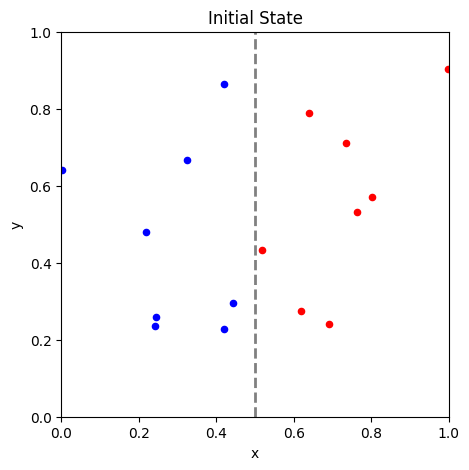

In [38]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(r[0][ixr].cpu(),r[1][ixr].cpu(), color='r', s=20)
ax.scatter(r[0][ixl].cpu(),r[1][ixl].cpu(), color='b', s=20)
ax.axvline(0.5, linestyle="--", color="grey", linewidth=2)

ax.set_xlim([0,1])
ax.set_ylim([0,1])

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Initial State")
plt.show()

Now we need to define velocities. We first initialize a velocity tensor with all 0 values. Then, we assign just a $v_x$ component to all particles, setting $v_x^r = -v_x^l$, so that right and left particles can move in opposite directions.

In [39]:
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500

To simplify the reference to each particle and identify in the following the colliding particles, we create a tensor of unique ids and a tensor with all possible pair combinations between particle ids.

In [40]:
ids = torch.arange(n_particles)

In [41]:
# create combintations
id_pairs = torch.combinations(ids,2).to(device)

We now need to compute the distance between all particles together since the distance will tell us whether the particles are colliding or not. We can do the computation all at once exploiting tensor algebra. The distance between particle $i$ and $j$ is:
$$
\Delta_{ij} = \sqrt{\Delta x_{ij}^2+\Delta y_{ij}^2}
$$
Let's create a tensor of x coordinates pairs:

In [42]:
id_pairs.shape

torch.Size([120, 2])

In [43]:
# first combinations : particle 0 and 1, particle 0 and 2, etc 
id_pairs[:2]

tensor([[0, 1],
        [0, 2]])

In [44]:
# The x coordinates of all particles appearing in the first column of combinations 
r[0][id_pairs[:,0]]

tensor([0.5186, 0.5186, 0.5186, 0.5186, 0.5186, 0.5186, 0.5186, 0.5186, 0.5186,
        0.5186, 0.5186, 0.5186, 0.5186, 0.5186, 0.5186, 0.6176, 0.6176, 0.6176,
        0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176, 0.6176,
        0.6176, 0.6176, 0.2431, 0.2431, 0.2431, 0.2431, 0.2431, 0.2431, 0.2431,
        0.2431, 0.2431, 0.2431, 0.2431, 0.2431, 0.2431, 0.9985, 0.9985, 0.9985,
        0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
        0.3234, 0.3234, 0.3234, 0.3234, 0.3234, 0.3234, 0.3234, 0.3234, 0.3234,
        0.3234, 0.3234, 0.2199, 0.2199, 0.2199, 0.2199, 0.2199, 0.2199, 0.2199,
        0.2199, 0.2199, 0.2199, 0.0031, 0.0031, 0.0031, 0.0031, 0.0031, 0.0031,
        0.0031, 0.0031, 0.0031, 0.8011, 0.8011, 0.8011, 0.8011, 0.8011, 0.8011,
        0.8011, 0.8011, 0.7636, 0.7636, 0.7636, 0.7636, 0.7636, 0.7636, 0.7636,
        0.7354, 0.7354, 0.7354, 0.7354, 0.7354, 0.7354, 0.6403, 0.6403, 0.6403,
        0.6403, 0.6403, 0.4426, 0.4426, 

In [45]:
# We stack the x coordinates of all particles in the first column of the combination with the x coordinates of all particles in the second column
# of the combination.
x_pairs = torch.stack([r[0][id_pairs[:,0]], r[0][id_pairs[:,1]]]).T

In [46]:
# A pair of x coordinates of a possible combination.
x_pairs[0]

tensor([0.5186, 0.6176])

In [47]:
x_pairs.shape

torch.Size([120, 2])

We have take the *transpose* to have a $n\times 2$ matrix where $n$ here is the number of possibile combinations. Since we have fixed the number of particles, we also have a fixed number of possible combinations given by:

In [48]:
tot_comb = int((n_particles*(n_particles-1))/2)
tot_comb

120

In [49]:
# Same with y
y_pairs = torch.stack([r[1][id_pairs[:,0]], r[1][id_pairs[:,1]]]).T

We can now compute the $\Delta x$ and $\Delta y$ differences, applying the `torch.diff` method, setting the `axis` of computation equal to 1, i.e. the column axis, since in our setting, the two columns are storing the x and y coordinates of the two particles making up each combination. Below we apply the `.ravel()` method to reshape the resulting tensor into a one-dimensional array.

In [50]:
x_pairs[0], torch.diff(x_pairs, axis=1)[0]

(tensor([0.5186, 0.6176]), tensor([0.0991]))

In [51]:
torch.diff(x_pairs, axis=1).shape

torch.Size([120, 1])

In [52]:
# We compute the difference along the first axis, i.e the columns since each row is a combination
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dy_pairs = torch.diff(y_pairs, axis=1).ravel()

In [53]:
d_pairs = torch.sqrt(dx_pairs**2 + dy_pairs**2)

To identify the colliding particles, we must first define a **cut-off** distance, which is the minimum distance between two particles that defines the colliding region. In a classical approach, we can assume that particles collide as soon as they "touch" each other, so we set the cut-off distance equal to double the radius of the particle: 

In [54]:
radius = 0.06
cutoff = radius*2

In [55]:
# Subsetting just combinations of colliding particles
ids_coll = id_pairs[d_pairs < cutoff]
ids_coll

tensor([[ 1, 15],
        [ 2, 13],
        [ 7,  8],
        [11, 14]])

Now, for each combination we call "1" the first particle and "2" the second particle. We need to identify the velocities of the first and of the second particle, but just for combinations defining colliding particles. We can again using indices to subset the velocity and position tensor:

In [56]:
v.shape

torch.Size([2, 16])

In [57]:
# e.g. for v1, taking every row (x, y coordinates) and for columns just ids_coll[:,0] i.e. all "first" particles in the colliding combination
v1 = v[:,ids_coll[:,0]]
v2 = v[:,ids_coll[:,1]]
r1 = r[:,ids_coll[:,0]]
r2 = r[:,ids_coll[:,1]]

We remind that an elastic collision between two bodies is a collision in which the total kinetic energy of the two bodies is conserved and no net conversion into other forms of energy occurs. In case of a two-dimensional collision,  from the conservation of the kinetic energy, one may prove that the velocities of the particles *after* collision, $\boldsymbol{v}_1'$ and $\boldsymbol{v}_2'$ are given by:
$$
\boldsymbol{v}_1' = \boldsymbol{v}_1 - \frac{2m_2}{m_1+m_2} \frac{\langle \boldsymbol{v}_1-\boldsymbol{v}_2, \boldsymbol{r}_1-\boldsymbol{r}_2\rangle}{||\boldsymbol{x}_1-\boldsymbol{x}_2||^2}(\boldsymbol{x}_1-\boldsymbol{x}_2)
$$
and the same for $\boldsymbol{v}_2$ but exchanging $1\to 2$. $\langle \cdot, \cdot\rangle$ denotes the dot product between the two vectors while $||\cdot ||^2$ denotes the norm. For our goals, we can assume to have particles of same mass $m_i = 1$:

In [58]:
v1_new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
v2_new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)

In [59]:
v1_new

tensor([[-500.,  500., -500.,  500.],
        [   0.,    0.,    0.,    0.]])

We have written all the relevant code to start our simulation. We can wrap everything up in the following three functions:
1. A function preparing the initial state, i.e. the position (randomly assigned), the velocity tensors given its module, the combination tensor
2. A function computing the distance between all particle pairs
3. A function computing the new velocities
4. A final function calling all the above in the right sequence to generate the simulated motion

In [60]:
def set_initial_state(N, v0):
    # define initial state position, velocity and combination tensors
    r = torch.rand((2,N)).to(device)

    # setting velocities for particles coming from the left and the right
    ixr = r[0]>0.5 
    ixl = r[0]<=0.5 
    v = torch.zeros((2,N)).to(device)
    v[0][ixr] = -v0
    v[0][ixl] = v0
    
    ids = torch.arange(N)
    id_pairs = torch.combinations(ids,2).to(device)

    return r, v, id_pairs, ixr, ixl
    
         
def get_distance(r, id_pairs):
    dx = torch.diff(torch.stack([r[0][id_pairs[:,0]], r[0][id_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][id_pairs[:,0]], r[1][id_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2

def compute_new_velocities(v1, v2, r1, r2):
    v1_new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2_new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1_new, v2_new

def motion(N, v0, ts, dt, d_cutoff):
    # Set initial state
    r, v, id_pairs, ixr, ixl = set_initial_state(N, v0)

    # Generate a tensor to store all r and v at each time step
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    
    # Initialize first state
    rs[0] = r
    vs[0] = v
    
    for i in range(1,ts):
        # Defining colliding particles
        icoll = id_pairs[get_distance(r, id_pairs) < d_cutoff**2]
        # Compute new velocities
        v[:,icoll[:,0]], v[:,icoll[:,1]] = compute_new_velocities(v[:,icoll[:,0]], v[:,icoll[:,1]], r[:,icoll[:,0]], r[:,icoll[:,1]])

        # Handling the case of particles "exiting from the box". We invert their velocities so that they do not exit.
        # We need two handle 4 cases, because we are simulating particles in a 2d "square":
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])

        # Re-define positions according to classical equation of motion in absence of forces:
        r = r + v*dt

        # Setting the new position and velocities as element of the rs and vs tensors, storing the entire motion
        rs[i] = r
        vs[i] = v
    return rs, vs, ixr, ixl

In [61]:
N = 3000
dt = 8e-6
t_steps = 2000
v0 = 500
radius = 0.005

In [62]:
rs, vs, ixr, ixl = motion(N, v0, ts=t_steps, dt=dt, d_cutoff=2*radius)

Now that we have the entire motion stored in the two tensors `rs` and `vs` , we can create an animation using the `FuncAnimation` method of `matplotlib`. Basically, this method allows to create a gif where each frame is a snapshot of the motion; in our case, each frame represents a *state* of the motion, i.e. the positions of all particles stored in the `rs` tensor. For the sake of visualization, we represent particles as circles, drawn with the `plt.Circle` method:

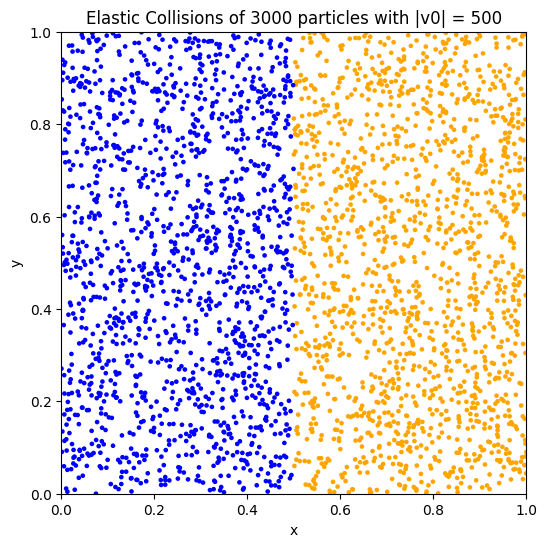

In [63]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

def animate(i):
    # Clear axis at each step
    ax.clear()

    # Taking x and y of left and right particles, colored in two differ colors:
    xright, yright = rs[i][0][ixr], rs[i][1][ixr]
    xleft, yleft = rs[i][0][ixl],rs[i][1][ixl]
    
    circles_right = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xright,yright)]
    circles_left = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xleft,yleft)]

    # Creating a path collection
    orange_particles  = matplotlib.collections.PatchCollection(circles_right, facecolors='orange')
    blue_particles = matplotlib.collections.PatchCollection(circles_left, facecolors='blue')
    
    ax.add_collection(orange_particles)
    ax.add_collection(blue_particles)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

    # customize plot
    ax.set_title(f"Elastic Collisions of {N} particles with |v0| = {v0}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('collisions.gif',writer='pillow',fps=30,dpi=100)

Now, we can finally tackle the problem of determining the velocity distribution of our particles at each state of the motion and verify that such distribution indeed converges to a Maxwell-Boltzmann distribution. First of all, let's plot the Maxwell-Boltzmann. In two dimensions, one can easily show that the distribution reduces to:
$$
g(\boldsymbol{v}) = m\beta v \exp \left( -m\beta \frac{v^2}{2} \right)
$$
since $m\beta = \pi/(2\langle v \rangle^2)$, then, we can plot:

In [65]:
v = np.linspace(0, 2000, 1000)
mbeta = torch.pi/(2*(v0**2))
fv = mbeta*v*np.exp(-(mbeta*v**2) / 2)

At each state, the tensor `vs` collects the velocities of each particles. Indeed, we remind its shape:

In [66]:
vs[5].shape

torch.Size([2, 3000])

two rows (the x and y components) and a number of columns equal to $N$ (the number of particles). Therefore, to compute the module of velocity vectors, we need to square, compute the sum along the 0 axis, i.e. summing x and y components (squared) and then take the square root. We finally plot the distribution using the `.hist()`function. Below, we plot both the Maxwell-Boltzmann distribution and the simulated distribution for a specific state of the motion:

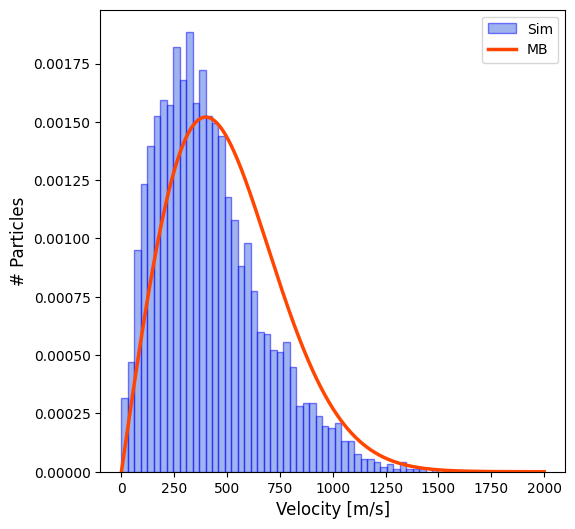

In [67]:
bins = np.linspace(0,1500,50)

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(torch.sqrt(torch.sum(vs[1000]**2, axis=0)), bins=bins, density=True, alpha=0.5, color="royalblue", edgecolor="blue", label="Sim")
ax.plot(v,fv, color="orangered", linewidth=2.5, label="MB")

ax.set_xlabel('Velocity [m/s]', fontsize=12)
ax.set_ylabel('# Particles', fontsize=12)
ax.legend()

Let's now simulate both the collisional motion and the evolution of the velocity distribution all together!!

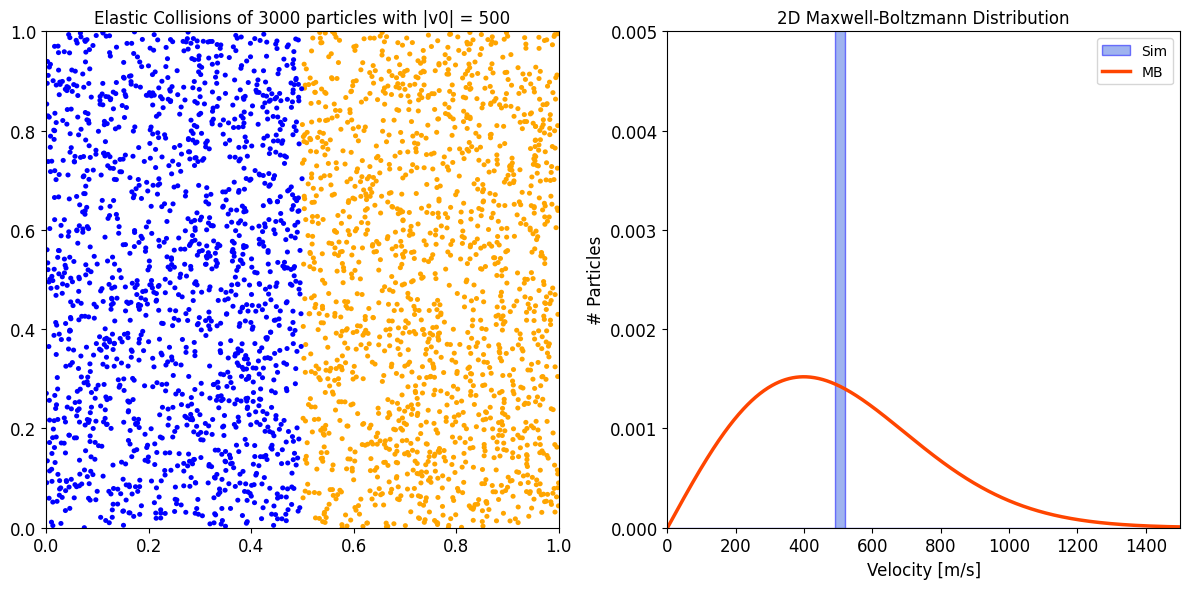

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

def animate(i):
    # Clear axis
    [ax.clear() for ax in axes]
    ax = axes[0]

    # Taking x and y of left and right particles, colored in two differ colors:
    xright, yright = rs[i][0][ixr], rs[i][1][ixr]
    xleft, yleft = rs[i][0][ixl],rs[i][1][ixl]
    
    circles_right = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xright,yright)]
    circles_left = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xleft,yleft)]

    # Creating a path collection
    orange_particles  = matplotlib.collections.PatchCollection(circles_right, facecolors='orange')
    blue_particles = matplotlib.collections.PatchCollection(circles_left, facecolors='blue')
    
    ax.add_collection(orange_particles)
    ax.add_collection(blue_particles)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    # customize plot
    ax.set_title(f"Elastic Collisions of {N} particles with |v0| = {v0}")
    
    # Plotting velocity distributions 
    ax = axes[1]
    bins = np.linspace(0,1500,50)
    
    ax.hist(torch.sqrt(torch.sum(vs[i]**2, axis=0)), bins=bins, density=True, alpha=0.5, color="royalblue", edgecolor="blue", label="Sim")
    ax.plot(v,fv, color="orangered", linewidth=2.5, label="MB")
    
    ax.set_xlim(0,1500)
    ax.set_ylim(0,0.005)

    # customize plot
    ax.set_title(f"2D Maxwell-Boltzmann Distribution")
    ax.set_xlabel('Velocity [m/s]', fontsize=12)
    ax.set_ylabel('# Particles', fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend()
    
    fig.tight_layout()
    
    
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('collisions+MB.gif',writer='pillow',fps=30,dpi=100)